In [1]:
from icalendar import Calendar
from datetime import datetime, timezone
from icalendar.prop import vText, vDDDTypes, vCalAddress
from pytz import timezone

import pandas as pd

# Export Calendar as *.ics file

CALENDAR_EXPLORT_FIlE_NAME = 'sitesh@tiqets.com.ics'

# Load calendar in pandas dataframe

g = open(CALENDAR_EXPLORT_FIlE_NAME, 'rb')
gcal = Calendar.from_ical(g.read())

TIMEZONE = str(next(x.get('TZID') for x in gcal.subcomponents if x.name == 'VTIMEZONE'))
gcal_events = filter(lambda component: component.name == 'VEVENT', gcal.subcomponents)

df = pd.DataFrame(gcal_events)

g.close()

# Parse dataframe into appropriate data types

for col in ['DTSTART', 'DTEND', 'CREATED', 'LAST-MODIFIED']:
    df[col] = pd.to_datetime(df[col].apply(vDDDTypes.from_ical), utc=True).dt.tz_convert(TIMEZONE)

for col in ['SUMMARY', 'DESCRIPTION', 'STATUS', 'LOCATION']:
    df[col] = df[col].astype('string')
    
df = df.loc[(df.DTSTART > timezone(TIMEZONE).localize(datetime(2018, 7, 1))) & (df.DTSTART < timezone(TIMEZONE).localize(datetime(2020, 7, 1)))]

# df.head()

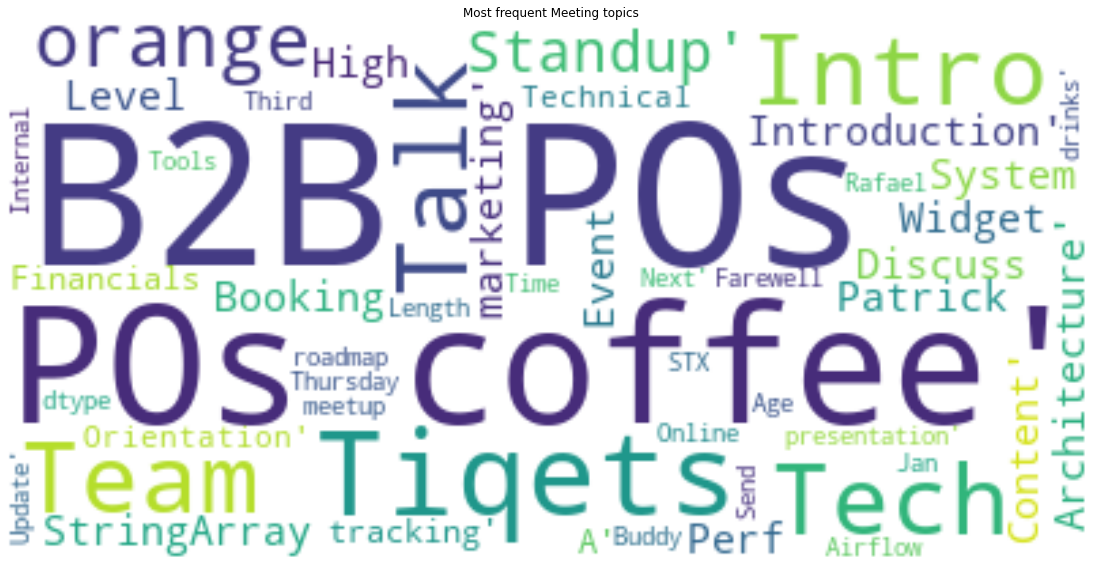

In [2]:
# Generate word cloud of meeting titles

from wordcloud import WordCloud
import matplotlib.pyplot as plt

summary_wordcloud = WordCloud(
    background_color='white',
    max_words=50,
#     min_font_size=10, 
#     max_font_size=30
).generate_from_text(str(df.SUMMARY.values))

plt.figure(figsize=(20,10))
plt.title('Most frequent Meeting topics')
plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

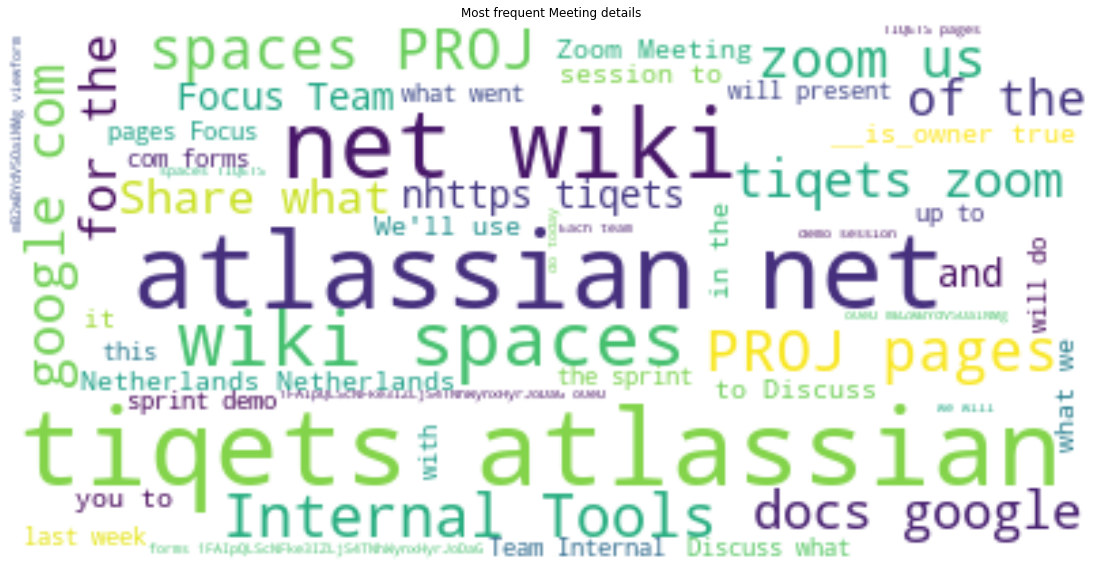

In [3]:
# Generate word cloud of meeting details

description_wordcloud = WordCloud(
    background_color='white', 
    stopwords = ['http', 'https', 'nbsp', 'href', 'src', '×', '!--...--', '!DOCTYPE', 'a', 'abbr', 'acronym', 'abbr', 'address', 'applet', 'embed', 'object', 'area', 'article', 'aside', 'audio', 'b', 'base', 'basefont', 'bdi', 'bdo', 'big', 'blockquote', 'body', 'br', 'button', 'canvas', 'caption', 'center', 'cite', 'code', 'col', 'colgroup', 'data', 'datalist', 'dd', 'del', 'details', 'dfn', 'dialog', 'dir', 'ul', 'div', 'dl', 'dt', 'em', 'embed', 'fieldset', 'figcaption', 'figure', 'font', 'footer', 'form', 'frame', 'frameset', 'h1 to h6', 'head', 'header', 'hr', 'html', 'i', 'iframe', 'img', 'input', 'ins', 'kbd', 'label', 'legend', 'li', 'link', 'main', 'map', 'mark', 'meta', 'meter', 'nav', 'noframes', 'noscript', 'object', 'ol', 'optgroup', 'option', 'output', 'p', 'param', 'picture', 'pre', 'progress', 'q', 'rp', 'rt', 'ruby', 's', 'samp', 'script', 'section', 'select', 'small', 'source', 'span', 'strike'],
    max_words=50,
#     min_font_size=10, 
#     max_font_size=30
).generate_from_text(str(df.DESCRIPTION.str.rsplit('-::~:~::~:~:').str.get(0).tolist()))

plt.figure(figsize=(20,10))
plt.title('Most frequent Meeting details')
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

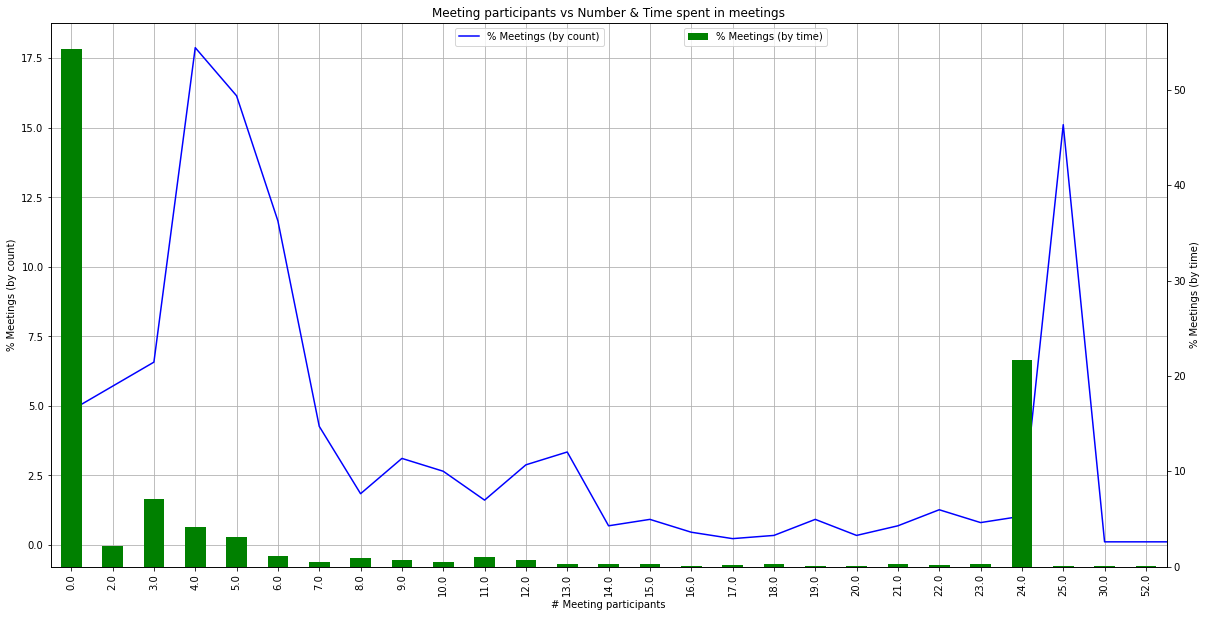

In [4]:
# Plot number of participants x time spent & count of meetings

from pandas import PeriodIndex
import numpy as np
from matplotlib import cm

df['attendee_count'] = df.ATTENDEE.str.len().fillna(0)
df['meeting_duration'] = (df.DTEND - df.DTSTART)

plt.figure(figsize=(20, 10))
plt.title('Meeting participants vs Number & Time spent in meetings')
meeting_attendee_axis = (df.groupby(['attendee_count'])['meeting_duration'].count() / df['meeting_duration'].count() * 100).plot(
    kind='line',
    color='blue',
    grid=True
)

(df.groupby(['attendee_count'])['meeting_duration'].sum() / df['meeting_duration'].sum() * 100).plot(
    kind='bar',
    color='green',
    ax=meeting_attendee_axis,
    grid=True,
    secondary_y=True
)

meeting_attendee_axis.set_xlabel('# Meeting participants')

meeting_attendee_axis.set_ylabel('% Meetings (by count)')
meeting_attendee_axis.legend(['% Meetings (by count)'], bbox_to_anchor=(0.5, 1.0))

meeting_attendee_axis.right_ax.set_ylabel('% Meetings (by time)')
meeting_attendee_axis.right_ax.legend(['% Meetings (by time)'], bbox_to_anchor=(0.7, 1.0))

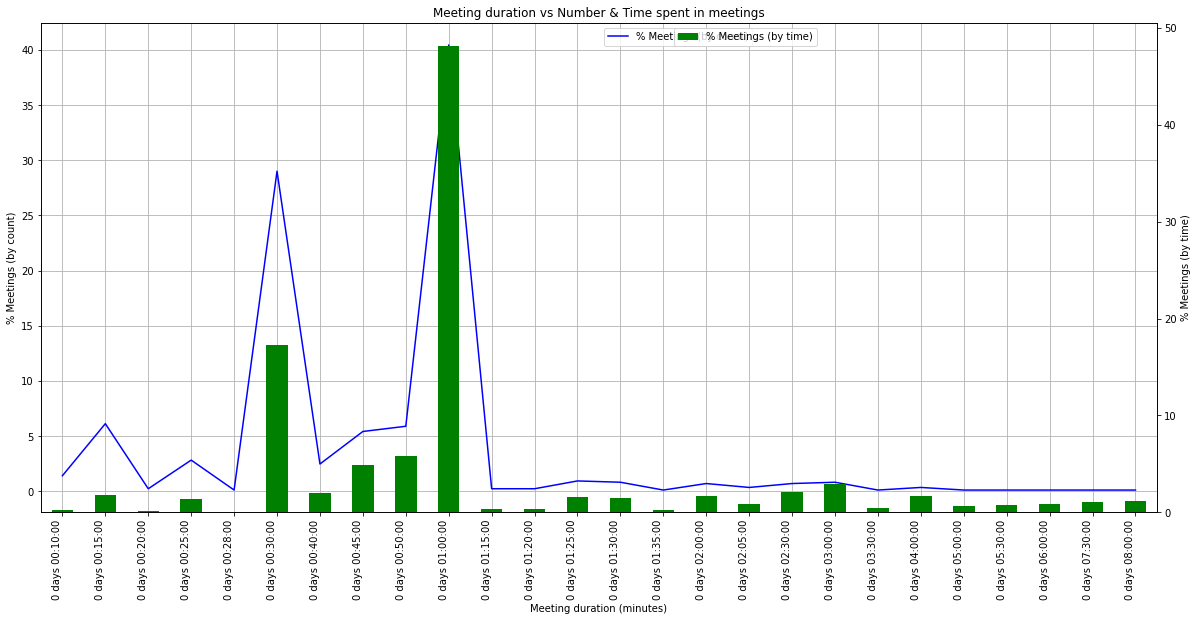

In [5]:
# Plot meeting duration x time spent & count of meetings

from pandas import PeriodIndex
import numpy as np
from matplotlib import cm
from datetime import timedelta

df_duration = df.loc[df.meeting_duration < timedelta(hours=12)].meeting_duration.value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.title('Meeting duration vs Number & Time spent in meetings')

meeting_duration_axis = (df_duration / df_duration.sum() * 100).plot(
    kind='line',
    color='blue',
    grid=True
)

for key, value in df_duration.iteritems():
    df_duration[key] *= key

(df_duration / df_duration.sum() * 100).plot(
    kind='bar',
    color='green',
    ax=meeting_duration_axis,
    grid=True,
    secondary_y=True
)

meeting_duration_axis.set_xlabel('Meeting duration (minutes)')

meeting_duration_axis.set_ylabel('% Meetings (by count)')
meeting_duration_axis.legend(['% Meetings (by count)'], bbox_to_anchor=(0.5, 1.0))

meeting_duration_axis.right_ax.set_ylabel('% Meetings (by time)')
meeting_duration_axis.right_ax.legend(['% Meetings (by time)'], bbox_to_anchor=(0.7, 1.0))

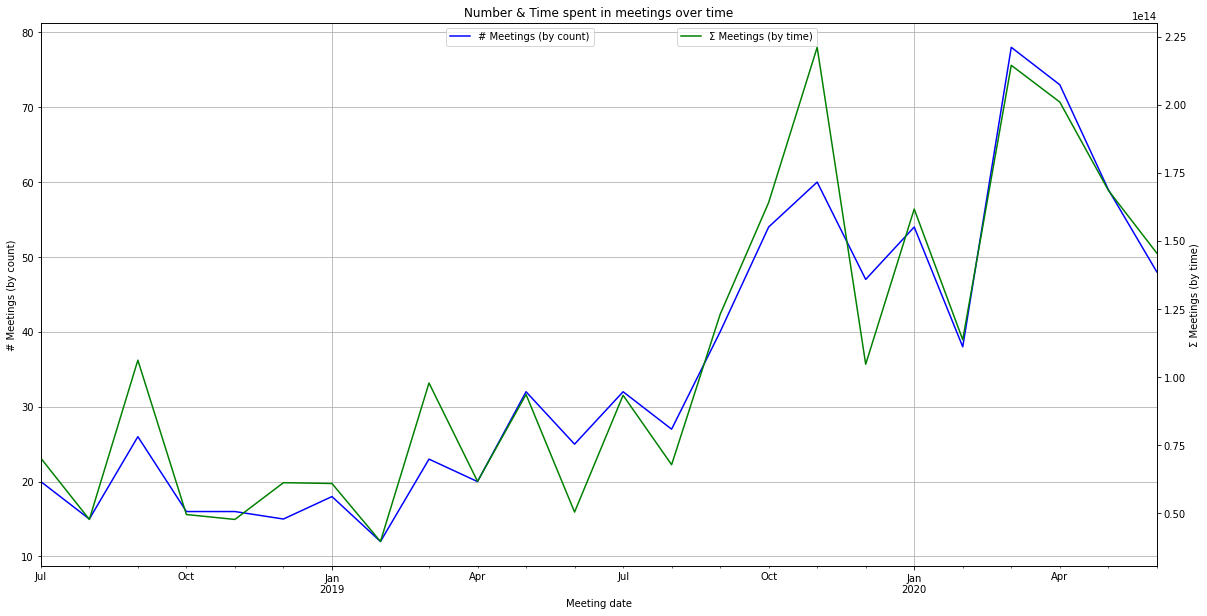

In [6]:
# Plot number of meetings & time spent over time

plt.figure(figsize=(20, 10))
plt.title('Number & Time spent in meetings over time')

df_meeting_timeline = df.loc[df.meeting_duration < timedelta(hours=12)].resample('M', on='DTSTART').agg({'DTEND': 'count', 'meeting_duration': 'sum'})

meeting_date_axis = df_meeting_timeline['DTEND'].plot(
    kind='line',
    color='blue',
    grid=True
)

df_meeting_timeline['meeting_duration'].plot(
    kind='line',
    color='green',
    ax=meeting_date_axis,
    grid=True,
    secondary_y=True
)

meeting_date_axis.set_xlabel('Meeting date')

meeting_date_axis.set_ylabel('# Meetings (by count)')
meeting_date_axis.legend(['# Meetings (by count)'], bbox_to_anchor=(0.5, 1.0))

meeting_date_axis.right_ax.set_ylabel('Σ Meetings (by time)')
meeting_date_axis.right_ax.legend(['Σ Meetings (by time)'], bbox_to_anchor=(0.7, 1.0))

<AxesSubplot:title={'center':'Overall meeting place location'}, xlabel='Meeting location', ylabel='% Meetings (by time)'>

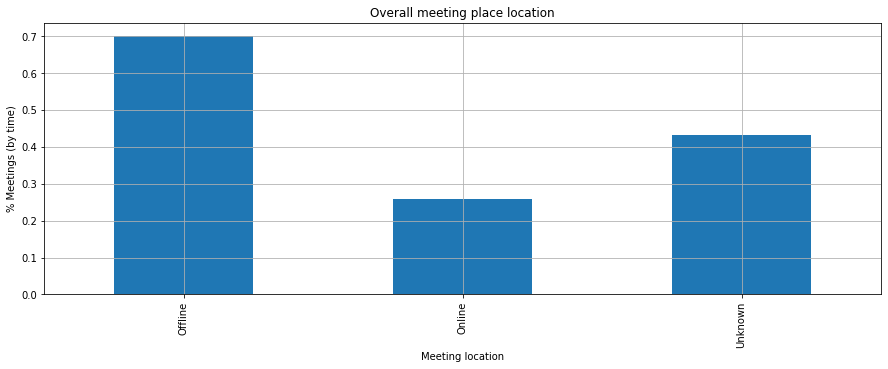

In [7]:
# Plot location of meeting (online : offline) x number & time spent in meetings

def get_location(location):
    if 'http' in location:
        return 'Online'
    elif location:
        return 'Offline'
    else:
        return 'Unknown'

df['meeting_location'] = df['LOCATION'].apply(lambda location: get_location(location.strip()))

plt.figure(figsize=(15,5))
plt.title('Overall meeting place location')

df['meeting_location'].value_counts(normalize=True).plot(
    kind='bar', 
    grid=True,
    ylabel='% Meetings (by count)',
    xlabel='Meeting location'
)

(df.groupby(['meeting_location'])['meeting_duration'].sum() / df['meeting_duration'].sum()).plot(
    kind='bar', 
    grid=True,
    ylabel='% Meetings (by time)', 
    xlabel='Meeting location'
)

Text(0, 0.5, '# Meetings (by count)')

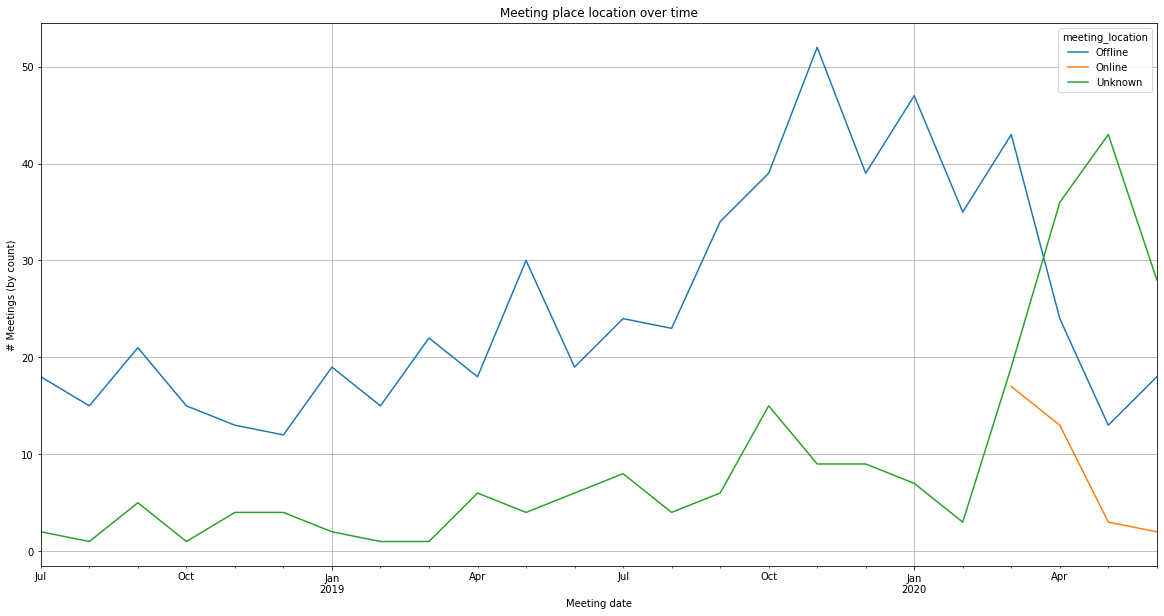

In [8]:
# Plot total ratio of online : offline meetings over time

df_location_timeline = df.groupby(
    [pd.Grouper(freq='1M', key='DTSTART'), 'meeting_location']
).agg({
    'DTEND': 'count',
    'meeting_duration': 'sum'
}).unstack()

meeting_location_date_axis = df_location_timeline['DTEND'].plot(
    kind='line',
    grid=True,
    figsize=(20, 10)
)

# df_location_timeline['meeting_duration'].plot(
#     kind='line',
#     ax=meeting_location_date_axis,
#     grid=True,
#     secondary_y=True,
# )

meeting_location_date_axis.set_title('Meeting place location over time')
meeting_location_date_axis.set_xlabel('Meeting date')
meeting_location_date_axis.set_ylabel('# Meetings (by count)')
# meeting_location_date_axis.right_ax.set_ylabel('Σ Meetings (by time)')

<AxesSubplot:title={'center':'Most common organizers for meetings attended'}, ylabel='Meeting organizer'>

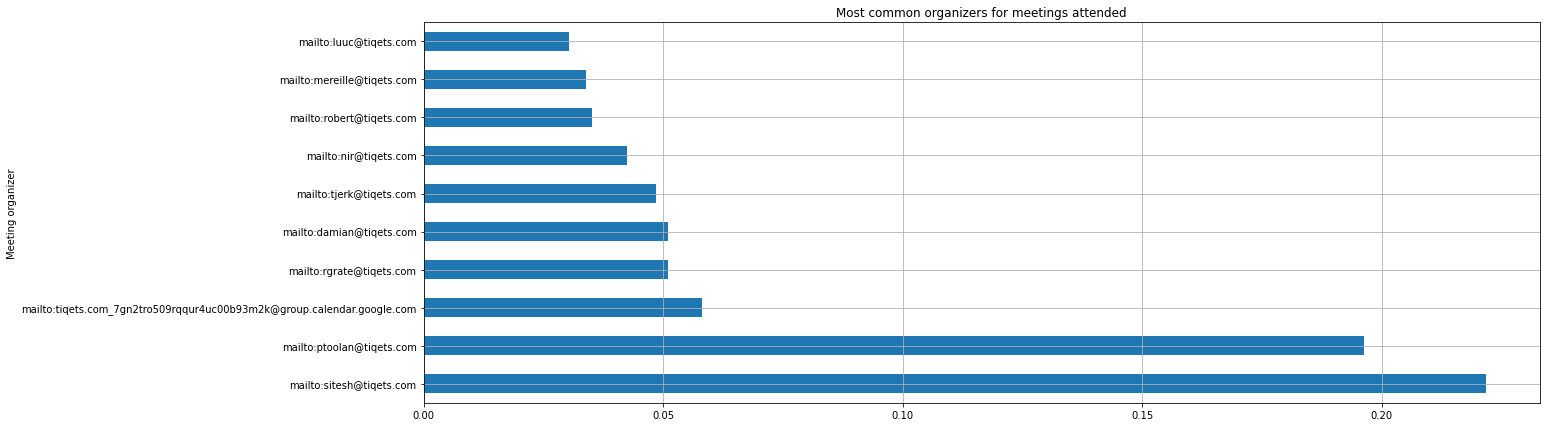

In [9]:
# Plot top 10 meeting organizers by count

df['ORGANIZER'].value_counts(normalize=True)[:10].plot(
    kind='barh', 
    grid=True,
    title='Most common organizers for meetings attended',
    ylabel='% Meetings (by count)', 
    xlabel='Meeting organizer',
    figsize=(20,7)
)

<AxesSubplot:title={'center':'Most common partipants in meetings attended'}, ylabel='Meeting attendee'>

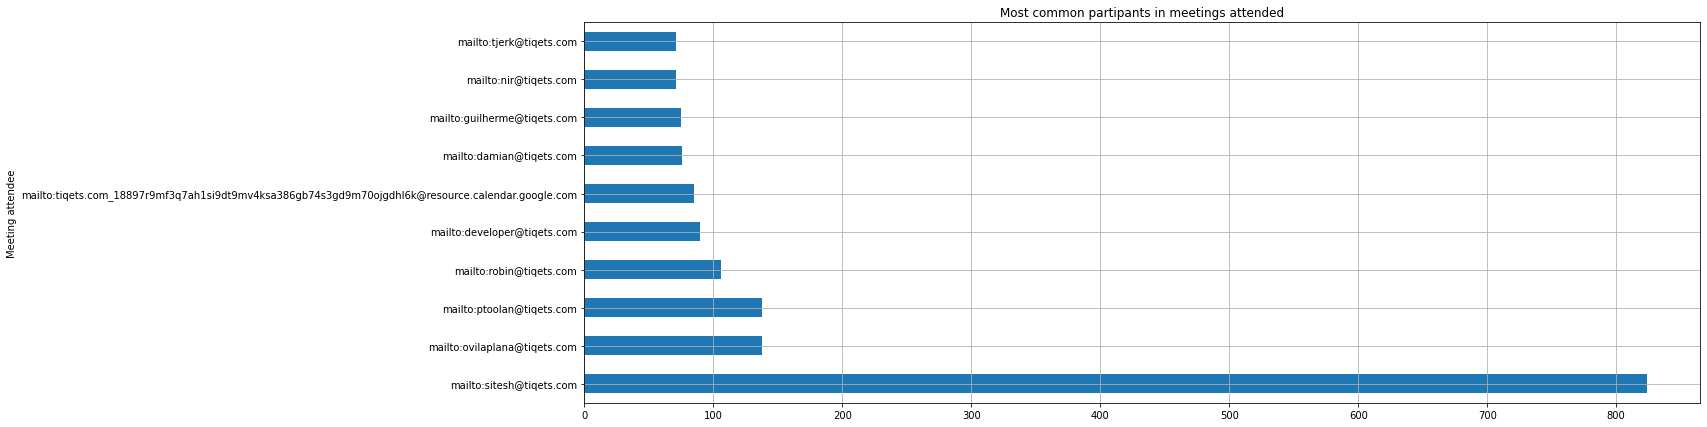

In [10]:
# Plot top 10 meeting participants by count

df.explode('ATTENDEE', ignore_index=True)['ATTENDEE'].value_counts()[:10].plot(
    kind='barh', 
    grid=True,
    title='Most common partipants in meetings attended',
    ylabel='% Meetings (by count)', 
    xlabel='Meeting attendee',
    figsize=(20,7)
)
